# Models Pipeline Notebook

In this notebook, we train two models to predict student exam scores:
1. **Artificial Neural Network (ANN)** using TensorFlow
2. **Ordinary Least Squares (OLS)** linear regression using Statsmodels

The workflow is as follows:
- Load the processed training and test data.
- Train the ANN, visualize training curves, and evaluate.
- Train the OLS model, visualize predictions, and use LinearRegDiagnostic for regression diagnostics.
- Save plots to both `/results/plots` and `/docker/images/learningBase`.
- Save trained models to `/results/trained_models`.
- Compare performance metrics of both approaches.


## 0. Import Libraries & Setup


In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow/Keras for ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Statsmodels for OLS
import statsmodels.api as sm

# Sklearn metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For saving objects
import pickle

# (Optional) for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define paths (adjust if needed)
data_dir = os.path.abspath(os.path.join('..', '..', 'data', 'processed'))
train_path = os.path.join(data_dir, 'training_data.csv')
test_path = os.path.join(data_dir, 'test_data.csv')

# Directory for saving models
trained_models_path = os.path.abspath(os.path.join('..','..','results','trained_models'))
os.makedirs(trained_models_path, exist_ok=True)

# Directory for learning-related outputs (e.g., Docker images)
learning_base_path = os.path.abspath(os.path.join('..','..','docker','images','learningBase'))
os.makedirs(learning_base_path, exist_ok=True)

# Add code directory to system path
code_path = os.path.abspath(os.path.join('..'))
if code_path not in sys.path:
    sys.path.insert(0, code_path)

In [2]:
# Import custom plot saver function
from utils.plot_saver import save_plot

# Import custom linear regression diagnostic
from utils.LinearRegDiagnostic import LinearRegDiagnostic

## 1. Load Preprocessed Data


In [3]:
print("Training data path:", train_path)
print("Test data path:    ", test_path)

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print("Training set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# Separate features (X) and target (y)
target_col = 'Exam_Score'
X_train = train_df.drop(columns=[target_col]).values
y_train = train_df[target_col].values

X_test = test_df.drop(columns=[target_col]).values
y_test = test_df[target_col].values

Training data path: /Users/iliasokolovskij/DataspellProjects/student-performance-predictor/data/processed/training_data.csv
Test data path:     /Users/iliasokolovskij/DataspellProjects/student-performance-predictor/data/processed/test_data.csv
Training set shape: (5178, 6)
Test set shape: (1295, 6)


## 2. Artificial Neural Network (ANN)

### 2.1 Define and Compile the Model

In [4]:
model = keras.Sequential([
    keras.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) # single output for regression
])

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

model.summary()

2025-02-02 01:05:48.605642: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-02-02 01:05:48.605680: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-02-02 01:05:48.605688: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1738454748.605703  188773 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1738454748.605723  188773 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,609 (18.00 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

### 2.2 Train the Model

In [5]:
epochs = 50
batch_size = 8

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/50


2025-02-02 01:06:24.074970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


648/648 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 2971.5903 - mae: 48.3294 - val_loss: 1.5280 - val_mae: 0.9830
Epoch 2/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.5867 - mae: 1.0034 - val_loss: 1.5414 - val_mae: 0.9894
Epoch 3/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.6156 - mae: 1.0131 - val_loss: 1.5060 - val_mae: 0.9763
Epoch 4/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.6507 - mae: 1.0236 - val_loss: 1.4795 - val_mae: 0.9624
Epoch 5/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.6956 - mae: 1.0382 - val_loss: 1.5142 - val_mae: 0.9682
Epoch 6/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.7543 - mae: 1.0568 - val_loss: 1.5997 - val_mae: 0.9923
Epoch 7/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.8254 - mae: 1.0796 - val_loss: 1.6638 - val_mae: 1.0139
Epoch 8/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.8850 - mae: 1.0984 - val_loss: 1.6811 - val_mae: 1.0224
Epoch 9/50
648/648 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 1.

### 2.3 Visualize Training History

Plot saved to: ../../results/plots/ann_loss_curve.png


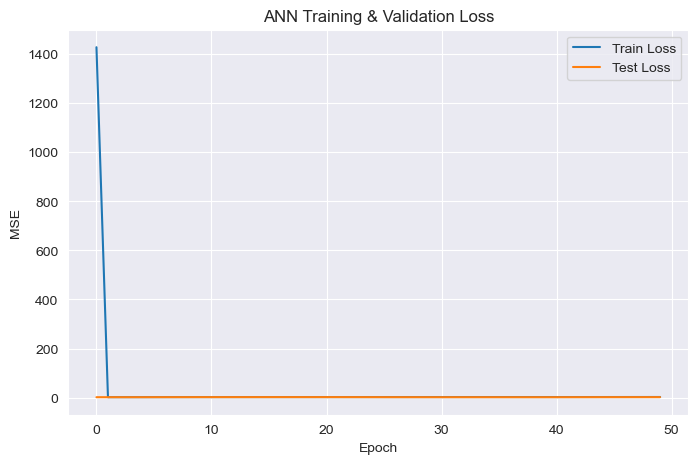

Plot saved to: ../../results/plots/ann_mae_curve.png


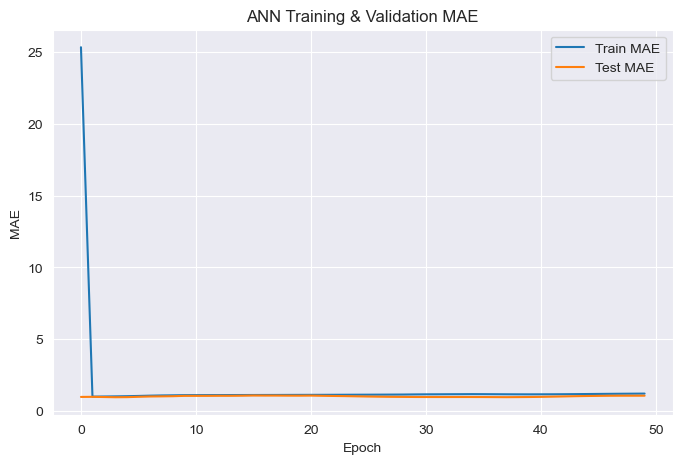

In [6]:
# Plot training & validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('ANN Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Save the figure using custom save_plot (results/plots) and also to learningBase
fig_loss = plt.gcf()  # get current figure
save_plot(fig_loss, 'ann_loss_curve.png')
fig_loss.savefig(os.path.join(learning_base_path, 'ann_loss_curve.png'), bbox_inches='tight')

plt.show()

# Plot training & validation MAE
plt.figure(figsize=(8,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Test MAE')
plt.title('ANN Training & Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

fig_mae = plt.gcf()
save_plot(fig_mae, 'ann_mae_curve.png')
fig_mae.savefig(os.path.join(learning_base_path, 'ann_mae_curve.png'), bbox_inches='tight')

plt.show()

### 2.4 Evaluate the ANN on the Test Set

In [7]:
y_pred_ANN = model.predict(X_test).flatten()

mse_ANN = mean_squared_error(y_test, y_pred_ANN)
mae_ANN = mean_absolute_error(y_test, y_pred_ANN)
r2_ANN = r2_score(y_test, y_pred_ANN)

print("=== ANN Performance on Test Set ===")
print("MSE :", mse_ANN)
print("MAE :", mae_ANN)
print("R^2 :", r2_ANN)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
=== ANN Performance on Test Set ===
MSE : 1.7851276721943774
MAE : 1.0681058375531642
R^2 : 0.8274205035702947


### 2.5 Scatter Plot of Predictions vs Actual

Plot saved to: ../../results/plots/ann_predictions_scatter.png


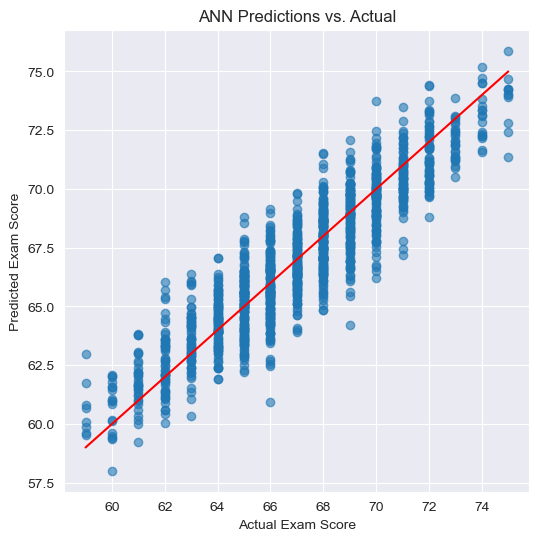

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_ANN, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('ANN Predictions vs. Actual')

fig_scatter_ann = plt.gcf()
save_plot(fig_scatter_ann, 'ann_predictions_scatter.png')
fig_scatter_ann.savefig(os.path.join(learning_base_path, 'ann_predictions_scatter.png'), bbox_inches='tight')
plt.show()

### 2.6 Residual Distribution Plot

Plot saved to: ../../results/plots/ann_residual_distribution.png


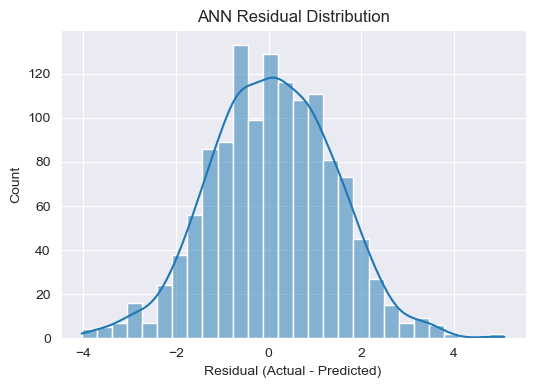

In [9]:
residuals_ANN = y_test - y_pred_ANN

plt.figure(figsize=(6,4))
sns.histplot(residuals_ANN, kde=True)
plt.title('ANN Residual Distribution')
plt.xlabel('Residual (Actual - Predicted)')

fig_resid_ann = plt.gcf()
save_plot(fig_resid_ann, 'ann_residual_distribution.png')
fig_resid_ann.savefig(os.path.join(learning_base_path, 'ann_residual_distribution.png'), bbox_inches='tight')
plt.show()

### 2.7 Save the Trained ANN Model

In [11]:
ann_model_path = os.path.join(trained_models_path, 'currentAiSolution.keras')
model.save(ann_model_path)
print(f"ANN model saved at: {ann_model_path}")

# Save training history as CSV
history_df = pd.DataFrame(history.history)
history_csv_path = os.path.join(trained_models_path, 'ann_training_metrics.csv')
history_df.to_csv(history_csv_path, index=False)
print(f"ANN training metrics saved to {history_csv_path}")

ANN model saved at: /Users/iliasokolovskij/DataspellProjects/student-performance-predictor/results/trained_models/currentAiSolution.keras
ANN training metrics saved to /Users/iliasokolovskij/DataspellProjects/student-performance-predictor/results/trained_models/ann_training_metrics.csv


---
## 3. Ordinary Least Squares (OLS) with Statsmodels


In [12]:
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test)

ols_model = sm.OLS(y_train, X_train_ols).fit()
print(ols_model.summary())

y_pred_OLS = ols_model.predict(X_test_ols)

mse_OLS = mean_squared_error(y_test, y_pred_OLS)
mae_OLS = mean_absolute_error(y_test, y_pred_OLS)
r2_OLS = r2_score(y_test, y_pred_OLS)

print("\n=== OLS Performance on Test Set ===")
print("MSE :", mse_OLS)
print("MAE :", mae_OLS)
print("R^2 :", r2_OLS)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     6180.
Date:                Sun, 02 Feb 2025   Prob (F-statistic):               0.00
Time:                        01:28:03   Log-Likelihood:                -8409.8
No. Observations:                5178   AIC:                         1.683e+04
Df Residuals:                    5172   BIC:                         1.687e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         67.0643      0.017   3928.204      0.0

### 3.1 Scatter Plot of OLS Predictions vs Actual

Plot saved to: ../../results/plots/ols_predictions_scatter.png


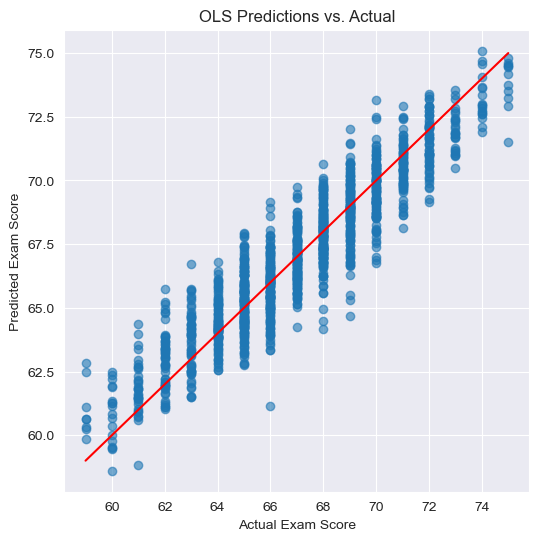

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_OLS, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.xlabel('Actual Exam Score')
plt.ylabel('Predicted Exam Score')
plt.title('OLS Predictions vs. Actual')

fig_scatter_ols = plt.gcf()
save_plot(fig_scatter_ols, 'ols_predictions_scatter.png')
fig_scatter_ols.savefig(os.path.join(learning_base_path, 'ols_predictions_scatter.png'), bbox_inches='tight')
plt.show()

### 3.2 Linear Regression Diagnostics Using `LinearRegDiagnostic`


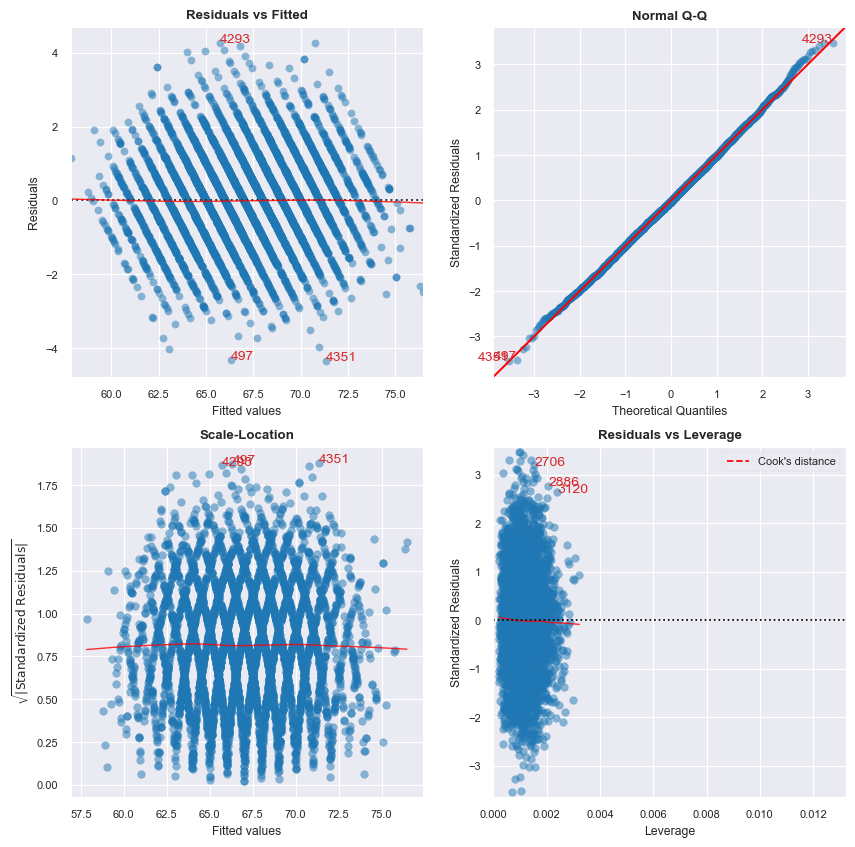

Diagnostic plots saved to PDF: /Users/iliasokolovskij/DataspellProjects/student-performance-predictor/docker/images/learningBase/OLS_DiagnosticPlots.pdf


In [15]:
# Create an instance of the diagnostic class with the fitted OLS model
diag = LinearRegDiagnostic(ols_model)

# Generate all diagnostic plots (they appear as a 2×2 figure)
vif_table, fig_diagnostics, ax = diag()

# Save the 2×2 subplot figure to learningBase
diag_pdf_path = os.path.join(learning_base_path, 'OLS_DiagnosticPlots.pdf')
fig_diagnostics.savefig(diag_pdf_path, format='pdf', bbox_inches='tight')
print(f"Diagnostic plots saved to PDF: {diag_pdf_path}")

plt.show()

### 3.3 Save the OLS Model


In [17]:
ols_model_path = os.path.join(trained_models_path, 'currentOlsSolution.pkl')
with open(ols_model_path, 'wb') as f:
    pickle.dump(ols_model, f)

print(f"OLS model saved at: {ols_model_path}")

# Save the OLS summary to a text file
ols_summary_path = os.path.join(trained_models_path, 'ols_model_summary.txt')
with open(ols_summary_path, 'w') as f:
    f.write(str(ols_model.summary()))

print(f"OLS summary saved at: {ols_summary_path}")

OLS model saved at: /Users/iliasokolovskij/DataspellProjects/student-performance-predictor/results/trained_models/currentOlsSolution.pkl
OLS summary saved at: /Users/iliasokolovskij/DataspellProjects/student-performance-predictor/results/trained_models/ols_model_summary.txt


---
## 4. Compare Model Performance


In [18]:
comparison_df = pd.DataFrame({
    "Model": ["ANN", "OLS"],
    "MSE": [mse_ANN, mse_OLS],
    "MAE": [mae_ANN, mae_OLS],
    "R^2": [r2_ANN, r2_OLS]
})

print("\n=== Model Performance Comparison ===")
print(comparison_df)


=== Model Performance Comparison ===
  Model       MSE       MAE       R^2
0   ANN  1.785128  1.068106  0.827421
1   OLS  1.464736  0.955963  0.858395
